# Investigate Attention on NRMS

In this file, we take a look at the learned attention weights of NRMS. Therefore, NRMS can be trained or loaded from Save_models/ (has to be downloaded via "Investigating_biases_in_News_Rec/utility_scripts/download_data_models.sh").

Loading necessary libraries and recommendation models/utils

In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
if "../recommenders" not in sys.path:
    sys.path.insert(0,"../recommenders")

import numpy as np
import pandas as pd

from recommenders.models.newsrec.models.nrms import NRMSModel

import wandb
from recommenders.models.deeprec.deeprec_utils import \
    download_deeprec_resources
from recommenders.models.newsrec.io.mind_iterator import MINDIterator
from recommenders.models.newsrec.newsrec_utils import (get_mind_data_set,
                                               prepare_hparams)

from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
K = tf.keras.backend

2023-01-01 18:21:22.875294: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Loading the trained models from 'Save_models/' . Available models are for history sizes 1,10,25,50 and 100 for NRMS

In [3]:
from recommenders_tests import load_small
from utils.loading_utils import from_idx_to_UID,from_idx_to_words

# Set the history size to 1,10,25,50 or 100
history_size = 100

train_news_file,train_behaviors_file,valid_news_file,valid_behaviors_file,wordEmb_file,userDict_file,wordDict_file,vertDict_file,subvertDict_file = load_small()
yaml_file = os.path.join("Dataset_small", "utils", r'nrms.yaml')

test_behaviors_file="Dataset_small/test/behaviors.tsv"

hparams= prepare_hparams(yaml_file, 
                        wordEmb_file=wordEmb_file,
                        wordDict_file=wordDict_file, 
                        userDict_file=userDict_file,
                        vertDict_file=vertDict_file, 
                        subvertDict_file=subvertDict_file,
                        batch_size=32,
                        his_size = history_size,
                        epochs=1)

iterator = MINDIterator
nrms = NRMSModel(hparams,iterator,42)


train_news_file = "Dataset_small/test/news.tsv"
train_behaviors_file = "Dataset_small/Users_with_n_behaviors/behaviors.tsv"

# Train Model for tests
if False:
    nrms, results = nrms.fit(train_news_file, train_behaviors_file, valid_news_file, valid_behaviors_file, valid_news_file,track_wand=False,results_as_list = True)
    nrms.save_weights('Save_models/content_model_weights', save_format='tf')    # Save results
# Load Model for tests
if True:
    nrms.model.load_weights(f"Save_models/NRMS_weights_hist_{history_size}/")

2023-01-01 18:25:33.954138: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-01 18:25:34.457469: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 73191600 exceeds 10% of free system memory.
2023-01-01 18:25:34.517521: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 73191600 exceeds 10% of free system memory.
2023-01-01 18:25:37.299801: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 73191600 exceeds 10% of free system memory.


In [4]:
def get_attention_nrms(model : NRMSModel,user_input):

    # Input runs to the two first layers
    inputs = model.userencoder.layers[0](user_input)
    inputs = model.userencoder.layers[1](inputs)

    # Weights for attention mechanism
    w_ = model.userencoder.layers[1].weights[4]
    b_ = model.userencoder.layers[1].weights[5]
    q_ = model.userencoder.layers[1].weights[6]

    # tanh(w.x + b) . q
    attention = K.tanh(K.dot(inputs, w_) + b_)
    attention = K.dot(attention, q_)

    attention = K.squeeze(attention, axis=2)

    # Mask out every padding news titel e.g. User has history size 12 and max history size is 100 than the first 88 values are masked out
    assert len(user_input.shape) == 3 , print("User input has to be of shape (batchsize, max_hist_size, max_title_size)")
    mask = np.count_nonzero(user_input != 0,axis=2)
    mask = mask != 0
    if mask is None:
            attention = K.exp(attention)
    else:
            attention = K.exp(attention) * K.cast(mask, dtype="float32")
    
    # Attention weights are basically probabilies 
    attention = K.exp(attention)

    attention_weight = attention / (
        K.sum(attention, axis=-1, keepdims=True) + K.epsilon()
    )
    
    attention_weight = K.expand_dims(attention_weight)

    return attention,attention_weight

def visualize_attention(scores_mat : np.array):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(scores_mat)))
        ax.set_yticks(range(len(scores_mat)))

        ax.set_xticklabels(scores_mat, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(scores_mat, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(scores_mat, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


for batch_data_input in tqdm(
            nrms.test_iterator.load_user_from_file(valid_news_file, valid_behaviors_file)
        ):
        with tf.compat.v1.Session() as sess:

            # This makes it possible to see tensor vectors
            init = tf.compat.v1.global_variables_initializer()
            sess.run(init)
            user_input = nrms._get_user_feature_from_iter(batch_data_input)
            
            # 1 x his_size x 30 
            # batchsize x history x titlelenght
            # Dim 1 : Batch
            # Dim 2 : News aus der History
            # Dim 3 : Word IDs welche Titel repräsentieren
                
            
            attention, att_weight = get_attention_nrms(nrms,user_input)
            
            att_weight = sess.run(att_weight)

            print(att_weight.shape)
            # visualize_attention(att_weight)

            # if you are using batches the outputs will be in batches
            # get exact attentions of chars
            an_attention_output = att_weight

            sorted_news = np.argsort(np.sum(att_weight[:,:,0],axis=0))[::-1]
            sorted_atts = np.sort(np.sum(att_weight[:,:,0],axis=0))[::-1]

            print(sorted_atts)
            print(sorted_news)
            dict_ = dict(zip(sorted_news,sorted_atts))

        break
        


0it [00:00, ?it/s]2023-01-01 18:25:55.102141: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
0it [00:14, ?it/s]

(32, 100, 1)
[0.66579795 0.66562057 0.6653533  0.6181583  0.60073644 0.5687406
 0.5545     0.55424625 0.5536796  0.5090644  0.47987124 0.46548524
 0.43736103 0.42318133 0.42217618 0.40896988 0.40889138 0.39591947
 0.39578885 0.37036636 0.3702651  0.3696959  0.36943626 0.36919796
 0.3580398  0.35774428 0.33422217 0.32199183 0.31074238 0.3105811
 0.31050456 0.31048098 0.31012097 0.2997739  0.29956928 0.29939064
 0.29923877 0.28910884 0.28910318 0.2787123  0.27865502 0.2687451
 0.2687249  0.26872125 0.2686998  0.26869717 0.26859388 0.26858523
 0.26849672 0.26849017 0.2684661  0.26846203 0.26845703 0.268451
 0.2683489  0.25985652 0.25984523 0.259819   0.25963128 0.2512299
 0.2512299  0.2512299  0.2512299  0.2512299  0.2512299  0.2512299
 0.2512299  0.2512299  0.2512299  0.2512299  0.2512299  0.2512299
 0.2512299  0.2512299  0.2512299  0.2512299  0.2512299  0.2512299
 0.2512299  0.2512299  0.2512299  0.2512299  0.2512299  0.2512299
 0.2512299  0.2512299  0.2512299  0.2512299  0.2512299  0.2

/home/langenhagen/.conda/envs/investigate_newsrec_bias/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


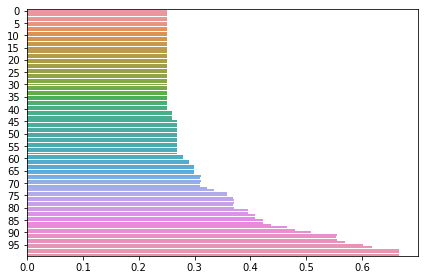

In [6]:
ax = sns.barplot(sorted_atts[::-1],sorted_news[::-1],orient='h')


plt.tight_layout()
ax.set_yticks(ax.get_yticks()[::5])
plt.show()